In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
filename="/content/drive/My Drive/HAM10000.zip"
with ZipFile(filename,'r') as zip:
  zip.extractall()
  print("done")


done


In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,GlobalAveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
data_pd = pd.read_csv('/content/drive/MyDrive/HAM10000_metadata.csv')
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
train_dir = os.path.join('HAM10000', 'train_dir')
test_dir = os.path.join('HAM10000', 'test_dir')

In [ ]:
df_count = data_pd.groupby('lesion_id').count()
df_count.head()

,image_id,dx,dx_type,age,sex,localization
lesion_id,,,,,,
HAM_0000000,2,2,2,2,2,2
HAM_0000001,1,1,1,1,1,1
HAM_0000002,3,3,3,3,3,3
HAM_0000003,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1


In [ ]:
df_count = df_count[df_count['dx'] == 1]
df_count.reset_index(inplace=True)

In [ ]:
def duplicates(x):
    unique = set(df_count['lesion_id'])
    if x in unique:
        return 'no' 
    else:
        return 'duplicates'

In [ ]:
data_pd['is_duplicate'] = data_pd['lesion_id'].apply(duplicates)
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates


In [ ]:
df_count = data_pd[data_pd['is_duplicate'] == 'no']

In [ ]:
train, test_df = train_test_split(df_count, test_size=0.15, stratify=df_count['dx'])

In [ ]:
def identify_trainOrtest(x):
    test_data = set(test_df['image_id'])
    if str(x) in test_data:
        return 'test'
    else:
        return 'train'

#creating train_df
data_pd['train_test_split'] = data_pd['image_id'].apply(identify_trainOrtest)
train_df = data_pd[data_pd['train_test_split'] == 'train']
train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate,train_test_split
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates,train


In [ ]:
test_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
5106,HAM_0004931,ISIC_0026428,nv,follow_up,50.0,male,lower extremity,no
6623,HAM_0001984,ISIC_0025092,nv,follow_up,50.0,male,trunk,no
5908,HAM_0001664,ISIC_0025217,nv,follow_up,50.0,male,back,no
4156,HAM_0005306,ISIC_0027056,nv,follow_up,60.0,male,back,no
4579,HAM_0002478,ISIC_0031787,nv,follow_up,60.0,female,unknown,no


In [ ]:
# Image id of train and test images
train_list = list(train_df['image_id'])
test_list = list(test_df['image_id'])

In [ ]:
len(test_list)

828

In [ ]:
len(train_list)

9187

In [ ]:
# Set the image_id as the index in data_pd
data_pd.set_index('image_id', inplace=True)

In [ ]:
os.mkdir(train_dir)
os.mkdir(test_dir)

In [ ]:
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [ ]:
for i in targetnames:
  directory1=train_dir+'/'+i
  directory2=test_dir+'/'+i
  os.mkdir(directory1)
  os.mkdir(directory2)

In [ ]:
for image in train_list:
    file_name = image+'.jpg'
    label = data_pd.loc[image, 'dx']

    # path of source image 
    source = os.path.join('HAM10000', file_name)

    # copying the image from the source to target file
    target = os.path.join(train_dir, label, file_name)

    shutil.copyfile(source, target)

In [ ]:
for image in test_list:

    file_name = image+'.jpg'
    label = data_pd.loc[image, 'dx']

    # path of source image 
    source = os.path.join('HAM10000', file_name)

    # copying the image from the source to target file
    target = os.path.join(test_dir, label, file_name)

    shutil.copyfile(source, target)

In [ ]:
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Augmenting images and storing them in temporary directories 
for img_class in targetnames:

    #creating temporary directories
    # creating a base directory
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # creating a subdirectory inside the base directory for images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    img_list = os.listdir('HAM10000/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir 
    for file_name in img_list:

        # path of source image in training directory
        source = os.path.join('HAM10000/train_dir/' + img_class, file_name)

        # creating a target directory to send images 
        target = os.path.join(img_dir, file_name)

        # copying the image from the source to target file
        shutil.copyfile(source, target)

    # Temporary augumented dataset directory.
    source_path = aug_dir

    # Augmented images will be saved to training directory
    save_path = 'HAM10000/train_dir/' + img_class

    # Creating Image Data Generator to augment images
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(

        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'

    )

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(source_path,save_to_dir=save_path,save_format='jpg',target_size=(224, 224),batch_size=batch_size)

    # Generate the augmented images
    aug_images = 8000 

    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((aug_images - num_files) / batch_size))

    # creating 8000 augmented images per class
    for i in range(0, num_batches):
        images, labels = next(aug_datagen)

    # delete temporary directory 
    shutil.rmtree('aug_dir')


Found 304 images belonging to 1 classes.
Found 488 images belonging to 1 classes.
Found 1033 images belonging to 1 classes.
Found 109 images belonging to 1 classes.
Found 1079 images belonging to 1 classes.
Found 6042 images belonging to 1 classes.
Found 132 images belonging to 1 classes.


In [ ]:
train_path = 'HAM10000/train_dir'
test_path = 'HAM10000/test_dir'
batch_size=16

In [ ]:
datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

In [ ]:
image_size = 224
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches =datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)


Train Batches: 
Found 51699 images belonging to 7 classes.

Test Batches: 
Found 828 images belonging to 7 classes.


In [ ]:
MainInput=Input(shape=(224, 224, 3))

Convolution Layer1

In [ ]:
def convlayer1(input_value):
  conv1=Conv2D(filters=64, kernel_size=(3,3), strides=(2,2),activation="relu",padding="same")(input_value)
  conv1=BatchNormalization()(conv1)
  pool1=MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)
  return pool1

Convolution Layer2

In [ ]:
def convlayer2(input_value):
  conv2=Conv2D(filters=64, kernel_size=(3,3),activation="relu",padding="same")(input_value)
  conv2=BatchNormalization()(conv2)
  conv2=Conv2D(filters=64, kernel_size=(3,3),activation="relu",padding="same")(conv2)
  conv2=BatchNormalization()(conv2)

  resnet=add([input_value,conv2])
  resnet=Activation("relu")(resnet)
  return resnet

Convolution Layer3

In [ ]:
def convlayer3(input_value):
  conv3=Conv2D(filters=128, kernel_size=(3,3),activation="relu",padding="same")(input_value)
  conv3=BatchNormalization()(conv3)
  conv3=Conv2D(filters=128, kernel_size=(3,3),activation="relu",padding="same")(conv3)
  conv3=BatchNormalization()(conv3)


  skip=Conv2D(filters=128, kernel_size=(3,3),activation="relu",padding="same")(input_value)
  skip=BatchNormalization()(skip)

  resnet=add([skip,conv3])
  resnet=Activation("relu")(resnet)
  return resnet

Convolution Layer4

In [ ]:
def convlayer4(input_value):
  conv4=Conv2D(filters=256, kernel_size=(3,3),activation="relu",padding="same")(input_value)
  conv4=BatchNormalization()(conv4)
  conv4=Conv2D(filters=256, kernel_size=(3,3),activation="relu",padding="same")(conv4)
  conv4=BatchNormalization()(conv4)


  skip=Conv2D(filters=256, kernel_size=(3,3),activation="relu",padding="same")(input_value)
  skip=BatchNormalization()(skip)

  resnet=add([skip,conv4])
  resnet=Activation("relu")(resnet)
  return resnet

Convolution Layer5

In [ ]:
def convlayer5(input_value):
  conv5=Conv2D(filters=512, kernel_size=(3,3),activation="relu",padding="same")(input_value)
  conv5=BatchNormalization()(conv5)
  conv5=Conv2D(filters=512, kernel_size=(3,3),activation="relu",padding="same")(conv5)
  conv5=BatchNormalization()(conv5)


  skip=Conv2D(filters=512, kernel_size=(3,3),activation="relu",padding="same")(input_value)
  skip=BatchNormalization()(skip)

  resnet=add([skip,conv5])
  resnet=Activation("relu")(resnet)
  return resnet

Model Creation

Block 1

In [ ]:
block1=convlayer1(MainInput)

Block 2

In [ ]:
block2=convlayer2(block1)
for i in range(0,2):
  block2=convlayer2(block2)

Block 3

In [ ]:
maxpool=MaxPooling2D(pool_size=(2,2), padding='same')(block2)
block3=convlayer3(maxpool)

for i in range(0,3):
  block3=convlayer3(block3)

Block 4

In [ ]:
block4=convlayer4(block3)
for i in range(0,5):
  block4=convlayer4(block4)

Block 5

In [ ]:
maxpool=MaxPooling2D(pool_size=(2,2), padding='same')(block4)
block5=convlayer5(maxpool)
for i in range(0,2):
  block5=convlayer5(block5)

Output Layer

In [ ]:

output = GlobalAveragePooling2D()(block5)
output = Dense(7, activation='softmax')(output)
model = Model(inputs=MainInput, outputs=output)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.01,epsilon=0.1)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
class_weights = {   
                    0: 1.0,  # akiec
                    1: 1.0,  # bcc
                    2: 1.0,  # bkl
                    3: 1.0,  # df
                    4: 5.0,  # mel
                    5: 1.0,  # nv
                    6: 1.0,  # vasc
                }


checkpoint=  ModelCheckpoint(filepath = 'ResNet34.hdf5',monitor='val_accuracy',save_best_only=True,save_weights_only=True)




In [ ]:
Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=65, min_delta=0.001)
history = model.fit(train_batches,
                    steps_per_epoch=(len(train_df)/batch_size),
                    epochs=300,
                    verbose=2,
                    validation_data=test_batches,validation_steps=len(test_df)/batch_size,callbacks=[checkpoint,Earlystop],class_weight=class_weights)

Epoch 1/300
919/919 - 64s - loss: 2.6473 - accuracy: 0.2170 - val_loss: 1.4750 - val_accuracy: 0.5676
Epoch 2/300
919/919 - 55s - loss: 2.2916 - accuracy: 0.2835 - val_loss: 2.0243 - val_accuracy: 0.0918
Epoch 3/300
919/919 - 55s - loss: 2.0900 - accuracy: 0.3415 - val_loss: 1.1970 - val_accuracy: 0.6014
Epoch 4/300
919/919 - 55s - loss: 2.0123 - accuracy: 0.3785 - val_loss: 1.1959 - val_accuracy: 0.5507
Epoch 5/300
919/919 - 55s - loss: 1.9144 - accuracy: 0.3979 - val_loss: 1.2886 - val_accuracy: 0.5266
Epoch 6/300
919/919 - 55s - loss: 1.9097 - accuracy: 0.3999 - val_loss: 1.2674 - val_accuracy: 0.4674
Epoch 7/300
919/919 - 55s - loss: 1.8485 - accuracy: 0.4144 - val_loss: 1.0479 - val_accuracy: 0.6353
Epoch 8/300
919/919 - 55s - loss: 1.8112 - accuracy: 0.4310 - val_loss: 1.0838 - val_accuracy: 0.6353
Epoch 9/300
919/919 - 55s - loss: 1.7693 - accuracy: 0.4339 - val_loss: 1.2846 - val_accuracy: 0.5483
Epoch 10/300
919/919 - 55s - loss: 1.7714 - accuracy: 0.4430 - val_loss: 0.8658 - 

In [ ]:
from tensorflow.keras import models
model.load_weights("ResNet34.hdf5")

In [ ]:
predictions = model.predict(test_batches, steps=len(test_df)/batch_size, verbose=0)

In [ ]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report 
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.67      0.43      0.53        23
         bcc       0.66      0.81      0.72        26
         bkl       0.51      0.42      0.46        66
          df       0.40      0.33      0.36         6
         mel       0.42      0.47      0.44        34
          nv       0.93      0.95      0.94       663
        vasc       0.91      1.00      0.95        10

    accuracy                           0.86       828
   macro avg       0.64      0.63      0.63       828
weighted avg       0.86      0.86      0.86       828



In [ ]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("weighted Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='weighted')))

Precision: 0.8579773073301391
Recall: 0.8623188405797102
Accuracy: 0.8623188405797102
weighted Roc score: 0.942343551506816


In [ ]:

print("Precision: "+ str(precision_score(y_true, y_pred, average='macro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='macro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("Macro Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='macro')))

Precision: 0.6421695472447352
Recall: 0.6309057523891284
Accuracy: 0.8623188405797102
Macro Roc score: 0.9493826564692036


In [ ]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
tpr={}
fpr={}
roc_auc={}
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro Roc score: " + str(roc_auc["micro"]))

Precision: 0.8623188405797102
Recall: 0.8623188405797102
Accuracy: 0.8623188405797102
Micro Roc score: 0.9859399674827105


In [ ]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(7):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

The ROC AUC score of akiec is: 0.9693221712125304
The ROC AUC score of bcc is: 0.9913677345098791
The ROC AUC score of bkl is: 0.9049152946790742
The ROC AUC score of df is: 0.9253852392538524
The ROC AUC score of mel is: 0.9106904726626167
The ROC AUC score of nv is: 0.9441199323552265
The ROC AUC score of vasc is: 0.999877750611247


In [ ]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

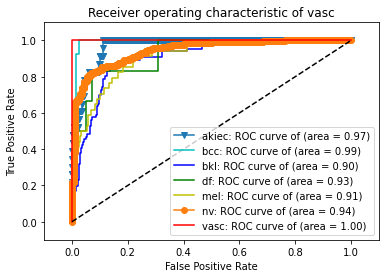

In [ ]:

plt.plot(fpr[0], tpr[0],'v-',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2],'b',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3],'g',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4],'y',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
plt.plot(fpr[5], tpr[5],'o-',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
plt.plot(fpr[6], tpr[6],'r',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of %s'%targetnames[i])
plt.legend(loc="lower right")
plt.show()